# Assessment of the incident power density on spherical human head model

In [2]:
import datetime
import itertools
import os
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d, Poly3DCollection
import numpy as np
import pandas as pd
from scipy.special import roots_legendre
from scipy.spatial import ConvexHull
import seaborn as sns
from tqdm.auto import tqdm

from dosipy.field import poynting
from dosipy.utils.dataloader import (load_antenna_el_properties,
                                     load_sphere_coords)
from dosipy.utils.derive import holoborodko
from dosipy.utils.integrate import elementwise_rectquad as equad
from dosipy.utils.viz import (fig_config, save_fig, set_axes_equal,
                              set_colorblind)

In [ ]:
print(f'platform: {jax.lib.xla_bridge.get_backend().platform}')

In [ ]:
# jax.config.update("jax_enable_x64", True)

In [7]:
set_colorblind()
%config InlineBackend.figure_format = 'retina'

In [ ]:
# utils

def cart2sph(x, y, z):
    """Return spherical given Cartesain coordinates."""
    r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    return r, theta, phi


def sph2cart(r, theta, phi):
    """Return Cartesian given Spherical coordinates."""
    x = r * jnp.cos(phi) * jnp.sin(theta)
    y = r * jnp.sin(phi) * jnp.sin(theta)
    z = r * jnp.cos(theta)
    return x, y, z

## Spatial distribution of the current along the dipole antenna operating at mmWaves

In [ ]:
# load pre-computed source data

f = 10e9  # operating frequency of the antenna
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
Is = jnp.asarray(Is)
xs = antenna_data.x.to_numpy()
xs = jnp.asarray(xs)

In [ ]:
# visualize the complex spatial distribution of the current @ 10 GHz

fig_config(latex=True, text_size=14, scaler=1, line_width=2)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(xs, jnp.abs(Is), 'k-', label=r'$|I(x)|$')
ax.plot(xs, Is.real, 'r--', label='$\\Re{[I(x)]}$')
ax.plot(xs, Is.imag, 'b-.', label='$\\Im{[I(x)]}$')
ax.set(xlabel=r'$x$ [m]', ylabel=r'$I(x)$ [A]')
ax.legend()
fig.tight_layout();

# fname = os.path.join('figures', 'I_dist')
# save_fig(fig, fname=fname)

## EM exposure of spherical model of the human head to dipole antenna at mmWaves

In [ ]:
# load pre-computed model coordinates

r_c = load_sphere_coords(2312)  # coordinates
d = -5 / 1000  # some fixed distance between the head model and the antenna
xs = xs - xs.max() / 2  # fix antenna position w.r.t. the model position
ys = jnp.zeros_like(xs) + r_c['y'].min() + d  # y-coordinates of the antenna
zs = jnp.zeros_like(xs)  # z-coordinates of the antenna
dx = xs[1] - xs[0]  # finite difference
Is_x = holoborodko(Is, dx)  # spatial distribution of the current gradients

In [ ]:
# compute EM power density values at each point of the model

S = r_c.apply(
    lambda row: poynting(row['x'], row['y'], row['z'], xs, ys, zs, f, Is, Is_x),
    axis=1, result_type='expand')
S.columns = ['Sx', 'Sy', 'Sz']
S_abs = S.apply(
    lambda row: jnp.sqrt(row['Sx'].real ** 2 + row['Sy'].real ** 2 + row['Sz'].real ** 2),
    axis=1)
S.loc[:, 'S_abs'] = S_abs

# update dataframe with computed power density values
r_c_calc = pd.concat([r_c, S], axis=1)

In [ ]:
# visualize absolute values of the power density on the model's surface

hull = ConvexHull(r_c_calc[['x', 'y', 'z']].to_numpy())
triangle_coords = hull.points[hull.simplices]

fig_config(latex=True, text_size=16, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.add_collection3d(Poly3DCollection(triangle_coords, color='white'))
ax.scatter(r_c_calc['x'], r_c_calc['y'], r_c_calc['z'],
           c=r_c_calc['S_abs'], cmap='viridis')
ax.plot(xs, ys, zs, 'r-', zorder=4,
        label=(f'dipole antenna\n$d = {-d * 1000}$ mm\n$f = {f / 1e9}$ GHz'))
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.05, 0.0, 0.05],
       yticks=[-0.05, 0.0, 0.05],
       zticks=[-0.05, 0.0, 0.05],
       xlim3d=[-0.1, 0.1],
       ylim3d=[-0.1, 0.1],
       zlim3d=[-0.1, 0.1])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 12
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 12

ax.legend()
ax.view_init(20, -60)
ax = set_axes_equal(ax)
fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_3D')
# save_fig(fig, fname=fname)

In [ ]:
# visualize absolute values of the power density from the POV of the dipole

fig_config(latex=True, text_size=16, scaler=1)
fig = plt.figure()
ax = fig.add_subplot()
ax.axis('equal')
cs = ax.scatter(r_c_calc['x'], r_c_calc['z'],
                c=r_c_calc['S_abs'], cmap='viridis')
#cbar = fig.colorbar(cs)
#cbar.ax.set_ylabel('$\\vec{S}$ [W/m$^2$]')
ax.plot(xs, zs, 'r-')
ax.set_xlim([-0.1, 0.1])
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$z$ [m]')
fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_2D')
# save_fig(fig, fname=fname)

In [ ]:
# define the averaging area for assessment of the incident power density

target_area = (2 / 100, 2 / 100)
A = target_area[0] * target_area[1]
target_area_origin = (-target_area[0]/2, -target_area[1]/2)

r_c_calc_ta = r_c_calc[
    (r_c_calc['y'] < 0) &
    (r_c_calc['x'] > target_area_origin[0]) &
    (r_c_calc['x'] < target_area_origin[0] * -1) &
    (r_c_calc['z'] > target_area_origin[1]) &
    (r_c_calc['z'] < target_area_origin[1] * -1)]
r_c_calc_ta.reset_index(drop=True, inplace=True)

xt = r_c_calc_ta['x'].to_numpy()
yt = r_c_calc_ta['y'].to_numpy()
zt = r_c_calc_ta['z'].to_numpy()

In [ ]:
# visualize absolute values of the power density across the averaging area

fig_config(latex=True, text_size=16, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')

cs = ax.scatter(xt, yt, zt, c=1/2 * r_c_calc_ta['S_abs'], cmap='viridis')
cbar = fig.colorbar(cs, pad=0.15)
cbar.ax.set_ylabel(r'$|\boldsymbol{S}|$ [W/m$^2$]')
ax.plot(xs, ys, zs, linestyle='-', c='r', zorder=1)
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20

fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_3D_zoomin')
# save_fig(fig, fname=fname)

In [ ]:
# generate Gauss-Legnedre integration nodes in spherical c.s. and convert to Cartesian

_, theta, phi = cart2sph(xt, yt, zt)
theta_a = theta.min()
theta_b = theta.max()
phi_a = phi.min()
phi_b = phi.max()
roots, weights = roots_legendre(20)
theta_points = 0.5 * (roots + 1.) * (theta_b - theta_a) + theta_a
theta_weights = 0.5 * weights * (theta_b - theta_a)
phi_points = 0.5 * (roots + 1.) * (phi_b - phi_a) + phi_a
phi_weights = 0.5 * weights * (phi_b - phi_a)

r = 0.09  # radius of the head model
phi_grid, theta_grid = jnp.meshgrid(phi_points, theta_points)
xt_spherical, yt_spherical, zt_spherical = sph2cart(r, theta_grid.ravel(), phi_grid.ravel())

In [ ]:
# compute the EM power density at integration nodes

Sx, Sy, Sz = [], [], []
for _xt, _yt, _zt in zip(xt_spherical, yt_spherical, zt_spherical):
    _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
    Sx.append(_Sx)
    Sy.append(_Sy)
    Sz.append(_Sz)
Sx = jnp.asarray(Sx)
Sy = jnp.asarray(Sy)
Sz = jnp.asarray(Sz)
Sr = 1/2 * np.sqrt(Sx.real ** 2 + Sy.real ** 2 + Sz.real ** 2)

In [ ]:
# visualize absolute values of the power density at integration nodes

fig_config(latex=True, text_size=16, scaler=1.5)

fig = plt.figure()
ax = plt.axes(projection ='3d')
cs = ax.scatter(xt_spherical, yt_spherical, zt_spherical, s=40,
                c=Sr, cmap='viridis')
cbar = fig.colorbar(cs, pad=0.2)
cbar.ax.set_ylabel(r'$|\boldsymbol{S}|$ [W/m$^2$]')
ax.plot(xs, ys, zs, linestyle='-', c='r')
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 17
ax.view_init(25, -50)
fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_3D_Gauss_mag')
# save_fig(fig, fname=fname)

In [ ]:
# visualize the power density vector field distribution across the averaging surface

fig_config(latex=True, text_size=16, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(xt_spherical[::3], yt_spherical[::3], zt_spherical[::3], s=40,
           ec='black', fc='None')
ax.plot(xs, ys, zs, linestyle='-', c='r', label='antenna')
q = ax.quiver(xt_spherical[::3], yt_spherical[::3], zt_spherical[::3],
              jnp.abs(Sx[::3]), jnp.abs(Sy[::3]), jnp.abs(Sz[::3]),
              linewidths=1, length=0.002, normalize=True, color='b',
              label='$\\boldsymbol{S}(x,y,z)$')
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20
ax.view_init(25, -40)
ax.legend()
fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_3D_Gauss_vec')
# save_fig(fig, fname=fname)

In [ ]:
# compute the incident power density (normal component), sPDn

nx, ny, nz = [], [], []
mag = 0
A_spherical = 0
for _theta, _w_theta in zip(theta_points, theta_weights):
    for _phi, _w_phi in zip(phi_points, phi_weights):
        # normal vector components
        _nx = r ** 2 * jnp.cos(_phi) * jnp.sin(_theta) ** 2 
        _ny = r ** 2 * jnp.sin(_phi) * jnp.sin(_theta) ** 2
        _nz = r ** 2 * jnp.cos(_theta) * jnp.sin(_theta)
        nx.append(_nx)
        ny.append(_ny)
        nz.append(_nz)
        # power density vector field
        _xt, _yt, _zt = sph2cart(r, _theta, _phi)
        _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
        # dot product between power density and normal vector
        _Sn = _Sx.real * _nx + _Sy.real * _ny + _Sz.real * _nz
        # incident power integration
        mag += _Sn * _w_theta * _w_phi
        # surface area integration
        A_spherical += jnp.sin(_theta) * r ** 2 * _w_theta * _w_phi
sPDn_spherical = mag / (2 * A_spherical)

print(f'spherical surface, sPDn = {sPDn_spherical:.4f} W/m2')

In [ ]:
# visualize the unit vector field distribution normal to the averaging surface

fig_config(latex=True, text_size=16, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(xt_spherical[::3], yt_spherical[::3], zt_spherical[::3], s=40,
           ec='black', fc='None')
ax.plot(xs, ys, zs, linestyle='-', c='r', label='antenna')
ax.quiver(xt_spherical[::3], yt_spherical[::3], zt_spherical[::3],
          nx[::3], ny[::3], nz[::3],
          linewidths=1, length=0.002, normalize=True, color='g',
          label='$\\boldsymbol{n}(x,y,z)$')
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20
ax.view_init(25, -40)
ax.legend()
fig.tight_layout();

# fname = os.path.join('figures', 'normals_3D_Gauss_vec')
# save_fig(fig, fname=fname)

In [ ]:
# visualize the normal component of the power density at integration nodes

n_norm = jnp.sqrt(jnp.asarray(nx) ** 2 + jnp.asarray(ny) ** 2 + jnp.asarray(nz) ** 2)
nx_normalized = jnp.asarray(nx) / n_norm
ny_normalized = jnp.asarray(ny) / n_norm
nz_normalized = jnp.asarray(nz) / n_norm
Sn = 1/2 * (Sx.real * nx_normalized + Sy.real * ny_normalized + Sz.real * nz_normalized)
fig_config(latex=True, text_size=16, scaler=1.5)

fig = plt.figure()
ax = plt.axes(projection ='3d')
cs = ax.scatter(xt_spherical, yt_spherical, zt_spherical, s=40,
                c=Sn, cmap='viridis')
cbar = fig.colorbar(cs, pad=0.2)
cbar.ax.set_ylabel(r'$\boldsymbol{S} \cdot \boldsymbol{n}$ [W/m$^2$]')
ax.plot(xs, ys, zs, linestyle='-', c='r')
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 17
ax.view_init(25, -50)
fig.tight_layout();

# fname = os.path.join('figures', 'PD_dist_3D_Gauss_n')
# save_fig(fig, fname=fname)

## EM exposure of planar tissue models to dipole antenna at mmWaves

In [ ]:
# generate coordinates of 3 different planar models for the averaging surface

yt_planar_near = yt_spherical.min()
yt_planar_far = yt_spherical.max()
yt_planar_mid = (yt_planar_far + yt_planar_near) / 2

xt_planar = jnp.linspace(-target_area[0]/2, target_area[0]/2, 11) + xs[-1] / 2
zt_planar = jnp.linspace(-target_area[1]/2, target_area[1]/2, 11)

In [ ]:
# visualize planar models relative to the spherical one

fig_config(latex=True, scaler=2)
fig = plt.figure()
ax = plt.axes(projection ='3d')

ax.scatter(xt_spherical, yt_spherical, zt_spherical, c='k', s=30,)
sur_planar_near = Rectangle(target_area_origin, target_area[0], target_area[1],
                  ec='r', ls='-', fc='None', lw=3, label='near')
sur_planar_mid = Rectangle(target_area_origin, target_area[0], target_area[1],
                  ec='b', ls='--', fc='None', lw=3, label='mid')
sur_planar_far = Rectangle(target_area_origin, target_area[0], target_area[1],
                  ec='g', ls='-.', fc='None', lw=3, label='far')
ax.add_patch(sur_planar_near)
ax.add_patch(sur_planar_mid)
ax.add_patch(sur_planar_far)
pathpatch_2d_to_3d(sur_planar_near, z=yt_planar_near, zdir='y')
pathpatch_2d_to_3d(sur_planar_mid, z=yt_planar_mid, zdir='y')
pathpatch_2d_to_3d(sur_planar_far, z=yt_planar_far, zdir='y')

ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[round(yt_planar_near, 4),
               round(yt_planar_mid, 4),
               round(yt_planar_far, 4)],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20
ax.view_init(30, -55)
ax.legend()
fig.tight_layout;

# fname = os.path.join('figures', 'surfaces')
# save_fig(fig, fname=fname)

In [ ]:
# incident power density (normal component) for planar model

def sPDn_planar_fn(yt_planar):
    S = np.empty((xt_planar.size, zt_planar.size))
    for xi, _xt in enumerate(xt_planar):
        for zi, _zt in enumerate(zt_planar):
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar, _zt, xs, ys, zs, f, Is, Is_x)
            S[xi, zi] = -jnp.real(_Sy)  # only normal component is considered
    return 1 / (2 * A) * equad(xt_planar, zt_planar, S)


sPDn_planar_near = sPDn_planar_fn(yt_planar_near)
sPDn_planar_mid = sPDn_planar_fn(yt_planar_mid)
sPDn_planar_far = sPDn_planar_fn(yt_planar_far)

In [ ]:
print(f'spherical surface of A = {A_spherical * 1e4:.2f} cm2, IPD = {sPDn_spherical:.4f} W/m2')
print(f'near planar surface of A = {A * 1e4:.2f} cm2, IPD = {sPDn_planar_near:.4f} W/m2')
print(f'mid planar surface of A = {A * 1e4:.2f} cm2, IPD = {sPDn_planar_mid:.4f} W/m2')
print(f'far planar surface of A = {A * 1e4:.2f} cm2, IPD = {sPDn_planar_far:.4f} W/m2')

## Intercomparisson

In [92]:
ds = np.array([2, 5, 10, 50, 150]) / -1000. # distance from the antenna
fs = np.array([3.5, 6., 10., 30., 60., 100.])  # frequencies in GHz
p = 11  # number of root points

### (1) Incident power density (normal component), $sPDn$, between 3 planar and a spherical tissue model

In [88]:
def sPDn_fn(f, d, p):
    assert f in [3.5, 6., 10., 26., 30., 60., 80., 100.]
    if f < 30:
        target_area = (2 / 100, 2 / 100)  # effective irradiated surface area, 4cm2
    else:
        target_area = (1 / 100, 1 / 100)  # effective irradiated surface area, 1cm2
    A = target_area[0] * target_area[1]  # area of the effective irradiated surface
    
    # target coordinates for curved model
    data = load_sphere_coords(2312)  # spherical head model coordinates
    target_area_origin = (-target_area[0]/2, -target_area[1]/2)
    data_target = data[  # effective irradiated skin surface
        (data['y'] < 0) &
        (data['x'] > target_area_origin[0]) &
        (data['x'] < target_area_origin[0] * -1) &
        (data['z'] > target_area_origin[1]) &
        (data['z'] < target_area_origin[1] * -1)]
    data_target.reset_index(drop=True, inplace=True)
    xt_spherical = data_target['x'].to_numpy()
    yt_spherical = data_target['y'].to_numpy()
    zt_spherical = data_target['z'].to_numpy()
    
    # source data
    f = f * 1e9
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    Is = jnp.asarray(Is)
    xs = antenna_data.x.to_numpy()
    xs = jnp.asarray(xs)
    xs = xs - xs.max() / 2
    ys = jnp.zeros_like(xs) + data_target['y'].min() + d
    zs = jnp.zeros_like(xs)
    dx = xs[1] - xs[0]
    Is_x = holoborodko(Is, dx)
    
    # target coordinates for planar model
    xt_planar = jnp.linspace(-target_area[0] / 2, target_area[0] / 2, p) + xs[-1] / 2
    yt_planar_near = yt_spherical.min()
    yt_planar_far = yt_spherical.max()
    yt_planar_mid = (yt_planar_far + yt_planar_near) / 2
    zt_planar = jnp.linspace(-target_area[1] / 2, target_area[1] / 2, p)
        
    # incident power density for planar model
    S_planar_near = np.empty((xt_planar.size, zt_planar.size))
    S_planar_mid = np.empty_like(S_planar_near)
    S_planar_far = np.empty_like(S_planar_near)
    for xi, _xt in enumerate(xt_planar):
        for zi, _zt in enumerate(zt_planar):
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_near, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_near[xi, zi] = -_Sy.real
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_mid, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_mid[xi, zi] = -_Sy.real
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_far, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_far[xi, zi] = -_Sy.real
    sPDn_planar_near = 1 / (2 * A) * equad(xt_planar, zt_planar, S_planar_near)
    sPDn_planar_mid = 1 / (2 * A) * equad(xt_planar, zt_planar, S_planar_mid)
    sPDn_planar_far = 1 / (2 * A) * equad(xt_planar, zt_planar, S_planar_far)   

    # generate Gaussian points in spherical c.s. and convert to Cartesian c.s.
    _, theta, phi = cart2sph(xt_spherical, yt_spherical, zt_spherical)
    theta_a = theta.min()
    theta_b = theta.max()
    phi_a = phi.min()
    phi_b = phi.max()
    theta_points, theta_weights = roots_legendre(p)
    phi_points, phi_weights = roots_legendre(p)
    theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
    theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
    phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
    phi_weights = 0.5 * phi_weights * (phi_b - phi_a)
    r = 0.09
    
    # incident power density for curved model
    mag = 0
    A_spherical = 0
    for _theta, _w_theta in zip(theta_points, theta_weights):
        for _phi, _w_phi in zip(phi_points, phi_weights):
            # normal vector components
            nx = r ** 2 * jnp.cos(_phi) * jnp.sin(_theta) ** 2 
            ny = r ** 2 * jnp.sin(_phi) * jnp.sin(_theta) ** 2
            nz = r ** 2 * jnp.cos(_theta) * jnp.sin(_theta)
            # power density vector field
            _xt, _yt, _zt = sph2cart(r, _theta, _phi)
            _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
            # dot product between power density and normal vector
            Sn = _Sx.real * nx + _Sy.real * ny + _Sz.real * nz
            # Gaussian quadrature
            mag += Sn * _w_theta * _w_phi
            A_spherical += jnp.sin(_theta) * r ** 2 * _w_theta * _w_phi
    sPDn_spherical = mag / (2 * A_spherical)
    return sPDn_planar_near, sPDn_planar_mid, sPDn_planar_far, sPDn_spherical

In [93]:
# (1) sPDn simulation

try:
    date = '2022-01-23'
    sPDn_comp = np.load(os.path.join('analysis', f'sPDn_sim_{date}.npy'))
    sPDn_comp_r = np.delete(sPDn_comp, np.where(sPDn_comp == -0.1)[0], axis=0)
    ds_r = np.delete(ds, np.where(ds == -0.1)[0])
except:
    sPDn_comp = np.zeros((ds.size * fs.size, 7))
    i = 0
    for d, f in tqdm(list(itertools.product(ds, fs))):
        sPDn_planar_near, sPDn_planar_mid, sPDn_planar_far, sPDn_spherical = sPDn_fn(f, d, p)
        sPDn_comp[i, :] = [f, d, p, sPDn_planar_near, sPDn_planar_mid, sPDn_planar_far, sPDn_spherical]
        i += 1
    np.save(os.path.join('analysis', f'sPDn_sim_{datetime.date.today()}.npy'), sPDn_comp)

[3.27643185 2.58151527 1.69134026 0.19832008 0.02500636] [3.27643185 2.58151527 1.69134026 0.19832008 0.02500636]
[5.55817162 3.82463858 2.22675962 0.20658276 0.02513216] [5.55817162 3.82463858 2.22675962 0.20658276 0.02513216]
[6.34332827 4.37294757 2.48256184 0.20949212 0.02517179] [6.34332827 4.37294757 2.48256184 0.20949212 0.02517179]
[21.17093099 10.49692638  4.1816243   0.22371101  0.02556728] [21.17093099 10.49692638  4.1816243   0.22371101  0.02556728]
[21.71196623 10.75730646  4.23383871  0.22384155  0.025568  ] [21.71196623 10.75730646  4.23383871  0.22384155  0.025568  ]
[21.80579474 10.81183539  4.24470602  0.2238622   0.02556787] [21.80579474 10.81183539  4.24470602  0.2238622   0.02556787]


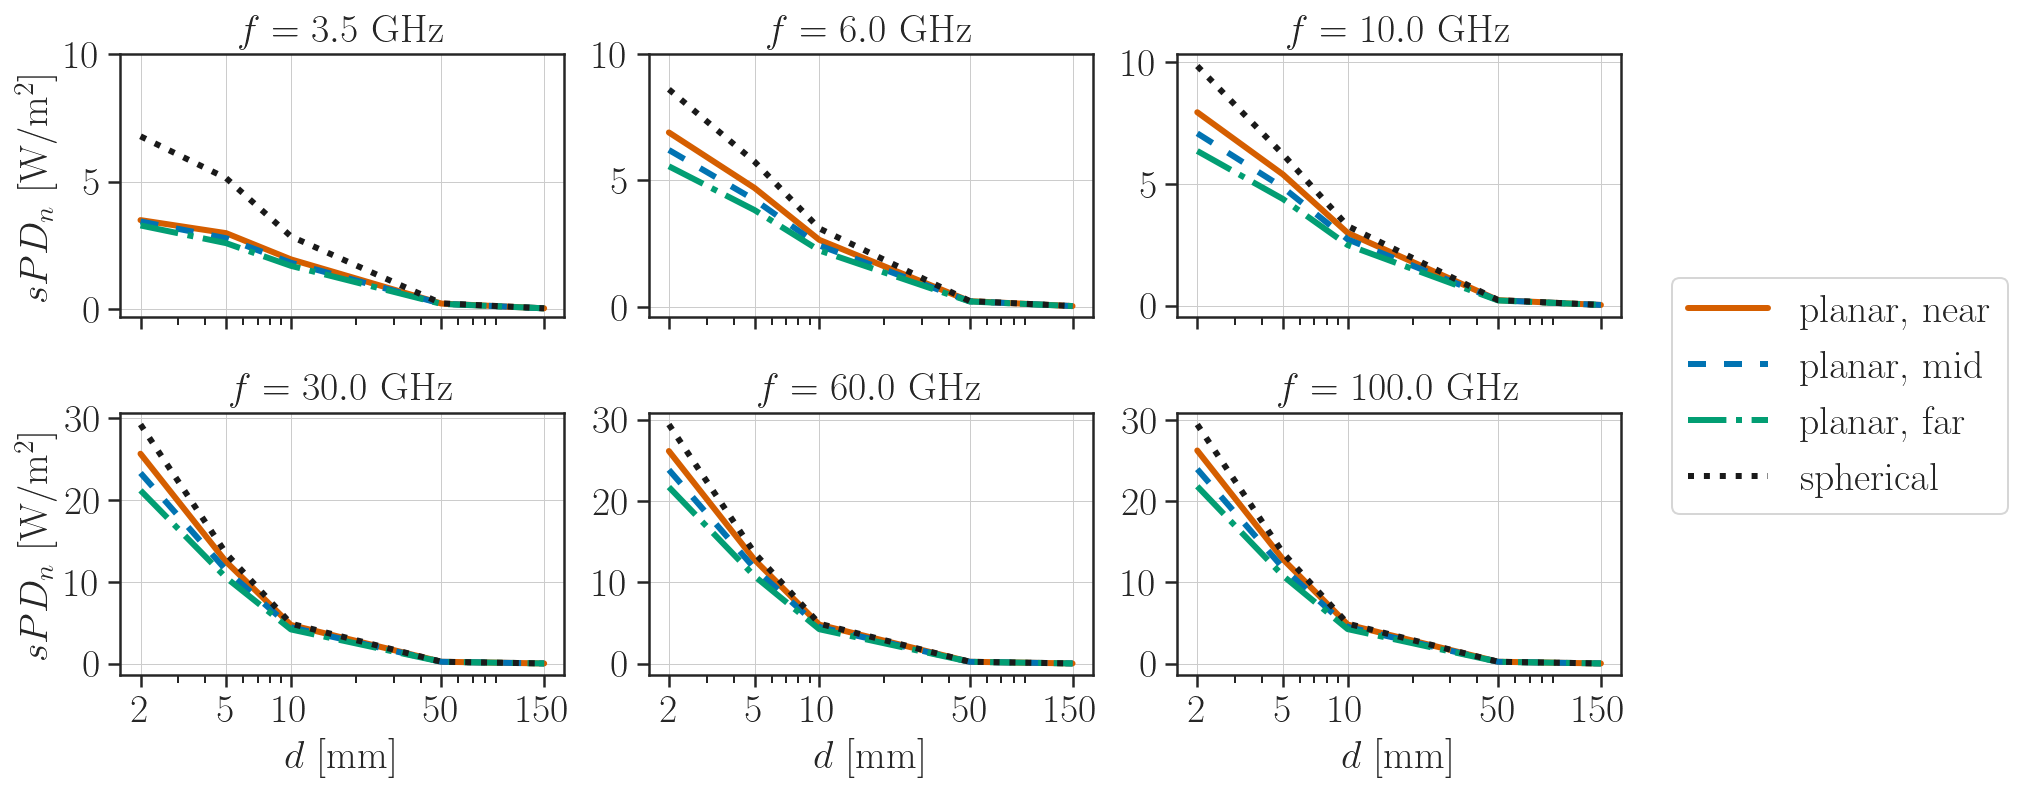

In [199]:
# visualize sPDn for planar models and the spherical model w.r.t. distances for range of frequencies

n_rows = 2
n_cols = 3
fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
f_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        axs[row, col].plot(np.abs(ds_r), sPDn_comp_r[f_idx::fs.size, 3], 'r-', label='planar, near')
        axs[row, col].plot(np.abs(ds_r), sPDn_comp_r[f_idx::fs.size, 4], 'b--', label='planar, mid')
        axs[row, col].plot(np.abs(ds_r), sPDn_comp_r[f_idx::fs.size, 5], 'g-.', label='planar, far')
        axs[row, col].plot(np.abs(ds_r), sPDn_comp_r[f_idx::fs.size, 6], 'k:', label='spherical')
        print(sPDn_comp_r[f_idx::fs.size, 5], sPDn_comp_r[f_idx::fs.size, 5])
        axs[row, col].set_xscale('log')
        axs[row, col].grid()
        axs[row, col].set_xticks(ticks=np.abs(ds_r),
                                 labels=np.asarray(ds_r * -1000, dtype='int'))
        if col == 0:
            axs[row, col].set(ylabel='$sPD_{n}$ [W/m$^2$]')
        if row == 1:
            axs[row, col].set(xlabel='$d$ [mm]')
            axs[row, col].set_yticks(ticks=[0, 10, 20, 30])
        else:
            axs[row, col].set_yticks(ticks=[0, 5, 10])
        axs[row, col].set(title=f'$f = {fs[f_idx]}$ GHz')
        f_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.8);

fname = os.path.join('figures', 'sPDn_d_sim')
save_fig(fig, fname=fname)

[0.48544204 0.42064553 0.31657913 0.04133779 0.00185765] [0.51631373 0.49699143 0.4057716  0.09759759 0.02372955]
[0.19822757 0.18148038 0.1459589  0.01416142 0.00153576] [0.35393578 0.3338917  0.28120664 0.07432475 0.02052468]
[0.19295955 0.13303617 0.08693106 0.0048037  0.00265695] [0.3546326  0.29545504 0.23920935 0.06638844 0.01946547]
[0.12223801 0.07536791 0.03319904 0.00160906 0.00040228] [0.27556863 0.21992719 0.14465532 0.03136108 0.00976839]
[0.11097266 0.06083198 0.02484599 0.0011397  0.0004552 ] [0.26163128 0.20913874 0.13848595 0.03092565 0.00971662]
[0.10872773 0.05772853 0.02302771 0.00103962 0.00046648] [0.25847295 0.20675668 0.13714182 0.03083239 0.00970552]


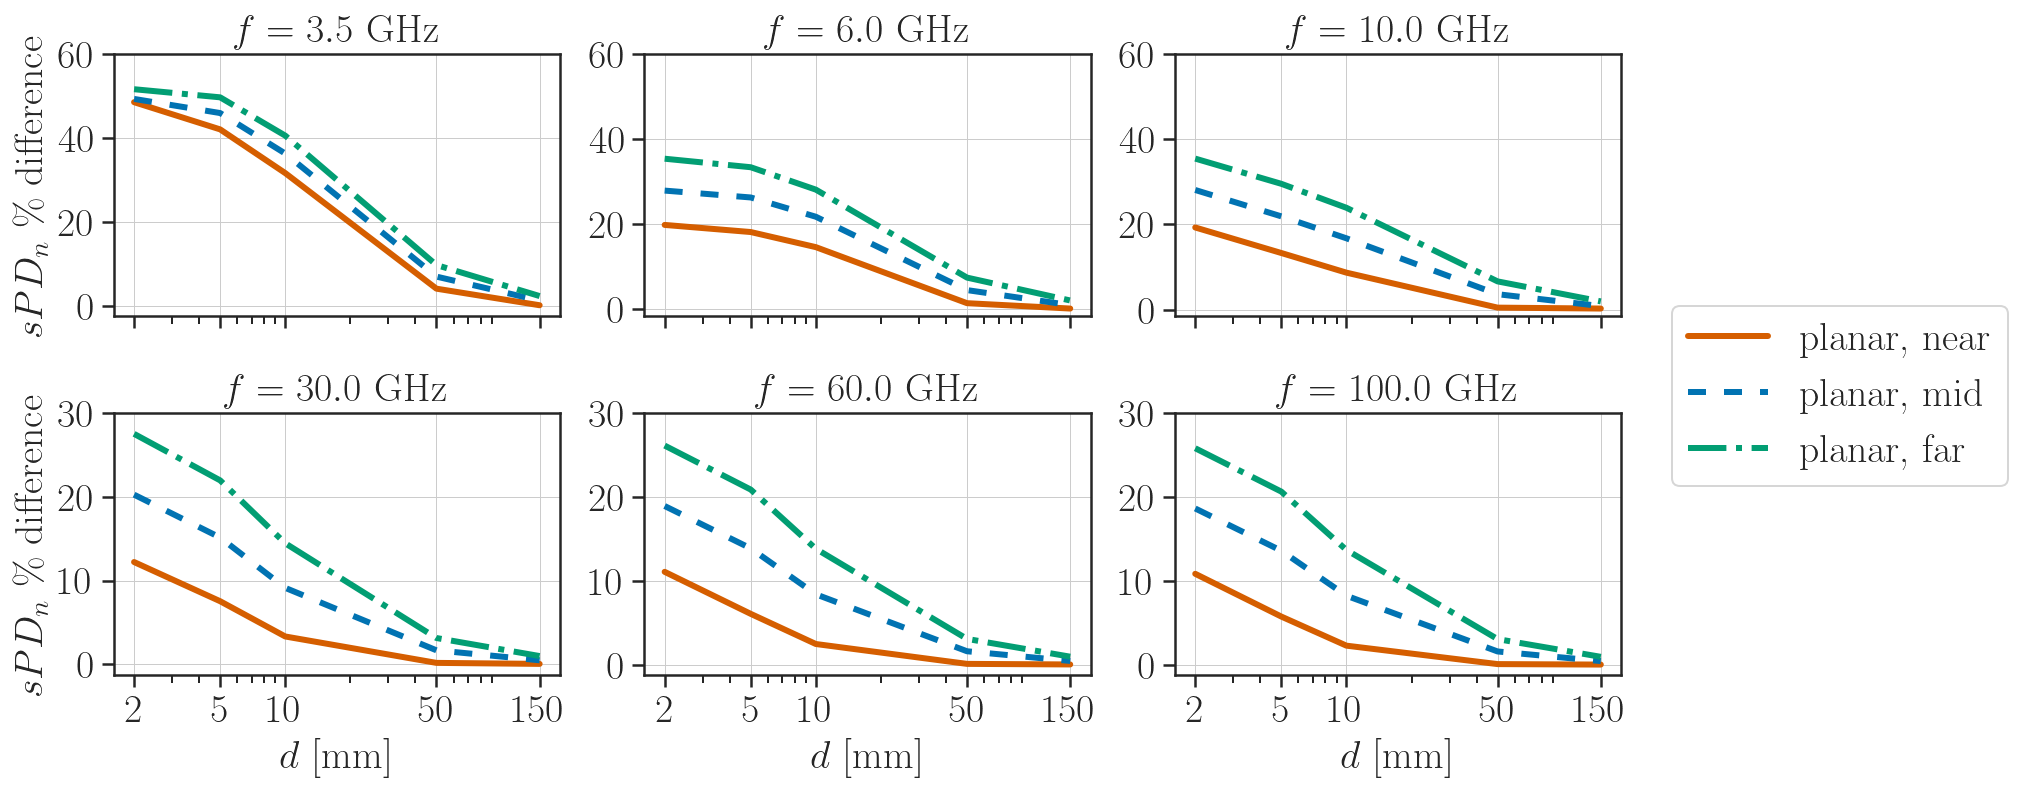

In [200]:
# visualize the absolute percentage difference in sPDn for planar models and the spherical model

fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
f_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        abs_diff_near = jnp.abs((sPDn_comp_r[f_idx::fs.size, 3] - sPDn_comp_r[f_idx::fs.size, 6]) / sPDn_comp_r[f_idx::fs.size, 6])
        abs_diff_mid = jnp.abs((sPDn_comp_r[f_idx::fs.size, 4] - sPDn_comp_r[f_idx::fs.size, 6]) / sPDn_comp_r[f_idx::fs.size, 6])
        abs_diff_far = jnp.abs((sPDn_comp_r[f_idx::fs.size, 5] - sPDn_comp_r[f_idx::fs.size, 6]) / sPDn_comp_r[f_idx::fs.size, 6])
        print(abs_diff_near, abs_diff_far)
        axs[row, col].plot(np.abs(ds_r), abs_diff_near * 100, 'r-', label='planar, near')
        axs[row, col].plot(np.abs(ds_r), abs_diff_mid * 100, 'b--', label='planar, mid')
        axs[row, col].plot(np.abs(ds_r), abs_diff_far * 100, 'g-.', label='planar, far')
        axs[row, col].set_xscale('log')
        axs[row, col].grid()
        axs[row, col].set_xticks(ticks=np.abs(ds_r),
                                 labels=np.asarray(ds_r * -1000, dtype='int'))
        if col == 0:
            axs[row, col].set(ylabel='$sPD_{n}$ \% difference')
        if row == 1:
            axs[row, col].set(xlabel='$d$ [mm]')
            axs[row, col].set_yticks(ticks=[0, 10, 20, 30])
        else:
            axs[row, col].set_yticks(ticks=[0, 20, 40, 60])
        axs[row, col].set(title=f'$f = {fs[f_idx]}$ GHz')
        f_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.8);

fname = os.path.join('figures', 'sPDn_d_diff')
save_fig(fig, fname=fname)

### (2) Incident power density (the norm), $sPDtot$, between 3 planar and a spherical tissue model

In [107]:
def sPDtot_fn(f, d, p):
    assert f in [3.5, 6., 10., 26., 30., 60., 80., 100.]
    if f < 30:
        target_area = (2 / 100, 2 / 100)  # effective irradiated surface area, 4cm2
    else:
        target_area = (1 / 100, 1 / 100)  # effective irradiated surface area, 1cm2
    target_area = (2 / 100, 2 / 100)
    
    # target coordinates for curved model
    data = load_sphere_coords(2312)  # spherical head model coordinates
    target_area_origin = (-target_area[0]/2, -target_area[1]/2)
    data_target = data[  # effective irradiated skin surface
        (data['y'] < 0) &
        (data['x'] > target_area_origin[0]) &
        (data['x'] < target_area_origin[0] * -1) &
        (data['z'] > target_area_origin[1]) &
        (data['z'] < target_area_origin[1] * -1)]
    data_target.reset_index(drop=True, inplace=True)
    xt_spherical = data_target['x'].to_numpy()
    yt_spherical = data_target['y'].to_numpy()
    zt_spherical = data_target['z'].to_numpy()
    
    # source data
    f = f * 1e9
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    Is = jnp.asarray(Is)
    xs = antenna_data.x.to_numpy()
    xs = jnp.asarray(xs)
    xs = xs - xs.max() / 2
    ys = jnp.zeros_like(xs) + data_target['y'].min() + d
    zs = jnp.zeros_like(xs)
    dx = xs[1] - xs[0]
    Is_x = holoborodko(Is, dx)
    
    # target coordinates for planar model
    xt_planar = jnp.linspace(-target_area[0] / 2, target_area[0] / 2, p) + xs[-1] / 2
    yt_planar_near = yt_spherical.min()
    yt_planar_far = yt_spherical.max()
    yt_planar_mid = (yt_planar_far + yt_planar_near) / 2
    zt_planar = jnp.linspace(-target_area[1] / 2, target_area[1] / 2, p)
        
    # incident power density for planar model
    S_planar_near = np.empty((xt_planar.size, zt_planar.size), dtype=np.complex64)
    S_planar_mid = np.empty_like(S_planar_near)
    S_planar_far = np.empty_like(S_planar_near)
    for xi, _xt in enumerate(xt_planar):
        for zi, _zt in enumerate(zt_planar):
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_near, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_near[xi, zi] = jnp.sqrt(_Sx.real ** 2 + _Sy.real ** 2 + _Sz.real ** 2)
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_mid, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_mid[xi, zi] = jnp.sqrt(_Sx.real ** 2 + _Sy.real ** 2 + _Sz.real ** 2)
            _Sx, _Sy, _Sz = poynting(_xt, yt_planar_far, _zt, xs, ys, zs, f, Is, Is_x)
            S_planar_far[xi, zi] = jnp.sqrt(_Sx.real ** 2 + _Sy.real ** 2 + _Sz.real ** 2)
    sPDtot_planar_near = 1 / (2 * A) * equad(xt_planar, zt_planar, abs(S_planar_near))
    sPDtot_planar_mid = 1 / (2 * A) * equad(xt_planar, zt_planar, abs(S_planar_mid))
    sPDtot_planar_far = 1 / (2 * A) * equad(xt_planar, zt_planar, abs(S_planar_far))
    
    
    # generate Gaussian points in spherical c.s. and convert to Cartesian c.s.
    _, theta, phi = cart2sph(xt_spherical, yt_spherical, zt_spherical)
    theta_a = theta.min()
    theta_b = theta.max()
    phi_a = phi.min()
    phi_b = phi.max()
    theta_points, theta_weights = roots_legendre(p)
    phi_points, phi_weights = roots_legendre(p)
    theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
    theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
    phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
    phi_weights = 0.5 * phi_weights * (phi_b - phi_a)
    r = 0.09
    
    # incident power density for curved model
    mag = 0
    A_spherical = 0
    for _theta, _w_theta in zip(theta_points, theta_weights):
        for _phi, _w_phi in zip(phi_points, phi_weights):
            # power density vector field
            _xt, _yt, _zt = sph2cart(r, _theta, _phi)
            _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
            Sabs = jnp.sqrt(_Sx.real ** 2 + _Sy.real ** 2 + _Sz.real ** 2)
            dA = r ** 2 * _w_theta * _w_phi
            # Gaussian quadrature
            mag += Sabs * dA
            A_spherical += jnp.sin(_theta) * r ** 2 * _w_theta * _w_phi
    sPDtot_spherical = mag / (2 * A_spherical)
    return sPDtot_planar_near, sPDtot_planar_mid, sPDtot_planar_far, sPDtot_spherical

In [109]:
# (2) sPDtot simulation

try:
    date = '2022-01-23'
    sPDtot_comp = np.load(os.path.join('analysis', f'sPDtot_sim_{date}.npy'))
    sPDtot_comp_r = np.delete(sPDtot_comp, np.where(sPDtot_comp == -0.1)[0], axis=0)
    ds_r = np.delete(ds, np.where(ds == -0.1)[0])
except:
    sPDtot_comp = np.zeros((ds.size * fs.size, 7))
    i = 0
    for d, f in tqdm(list(itertools.product(ds, fs))):
        sPDtot_planar_near, sPDtot_planar_mid, sPDtot_planar_far, sPDtot_spherical = sPDtot_fn(f, d, p)
        sPDtot_comp[i, :] = [f, d, p, sPDtot_planar_near, sPDtot_planar_mid, sPDtot_planar_far, sPDtot_spherical]
        i += 1
    np.save(os.path.join('analysis', f'sPDtot_sim_{datetime.date.today()}.npy'), sPDtot_comp)

[4.65250799 3.14472138 1.86719539 0.20185871 0.02509135] [10.33055305  6.20078421  3.06842136  0.2204572   0.02568109]
[7.68075763 4.63215675 2.46368585 0.20956925 0.02518544] [12.61099339  6.91969585  3.34298539  0.22394143  0.02572522]
[8.81720392 5.32750342 2.76262975 0.2121384  0.02521369] [14.25717354  7.50828934  3.54415464  0.22520699  0.02573772]
[2.70192105e+01 1.17598331e+01 4.39596185e+00 2.24457216e-01
 2.55772145e-02] [3.83757629e+01 1.49447184e+01 5.07716322e+00 2.31182620e-01
 2.58354954e-02]
[2.79480125e+01 1.21074993e+01 4.45539688e+00 2.24548523e-01
 2.55773216e-02] [3.89688263e+01 1.51781120e+01 5.11177349e+00 2.31214911e-01
 2.58348659e-02]
[2.81465399e+01 1.21849485e+01 4.46826159e+00 2.24560953e-01
 2.55770642e-02] [3.90940285e+01 1.52296705e+01 5.11908340e+00 2.31214389e-01
 2.58344356e-02]


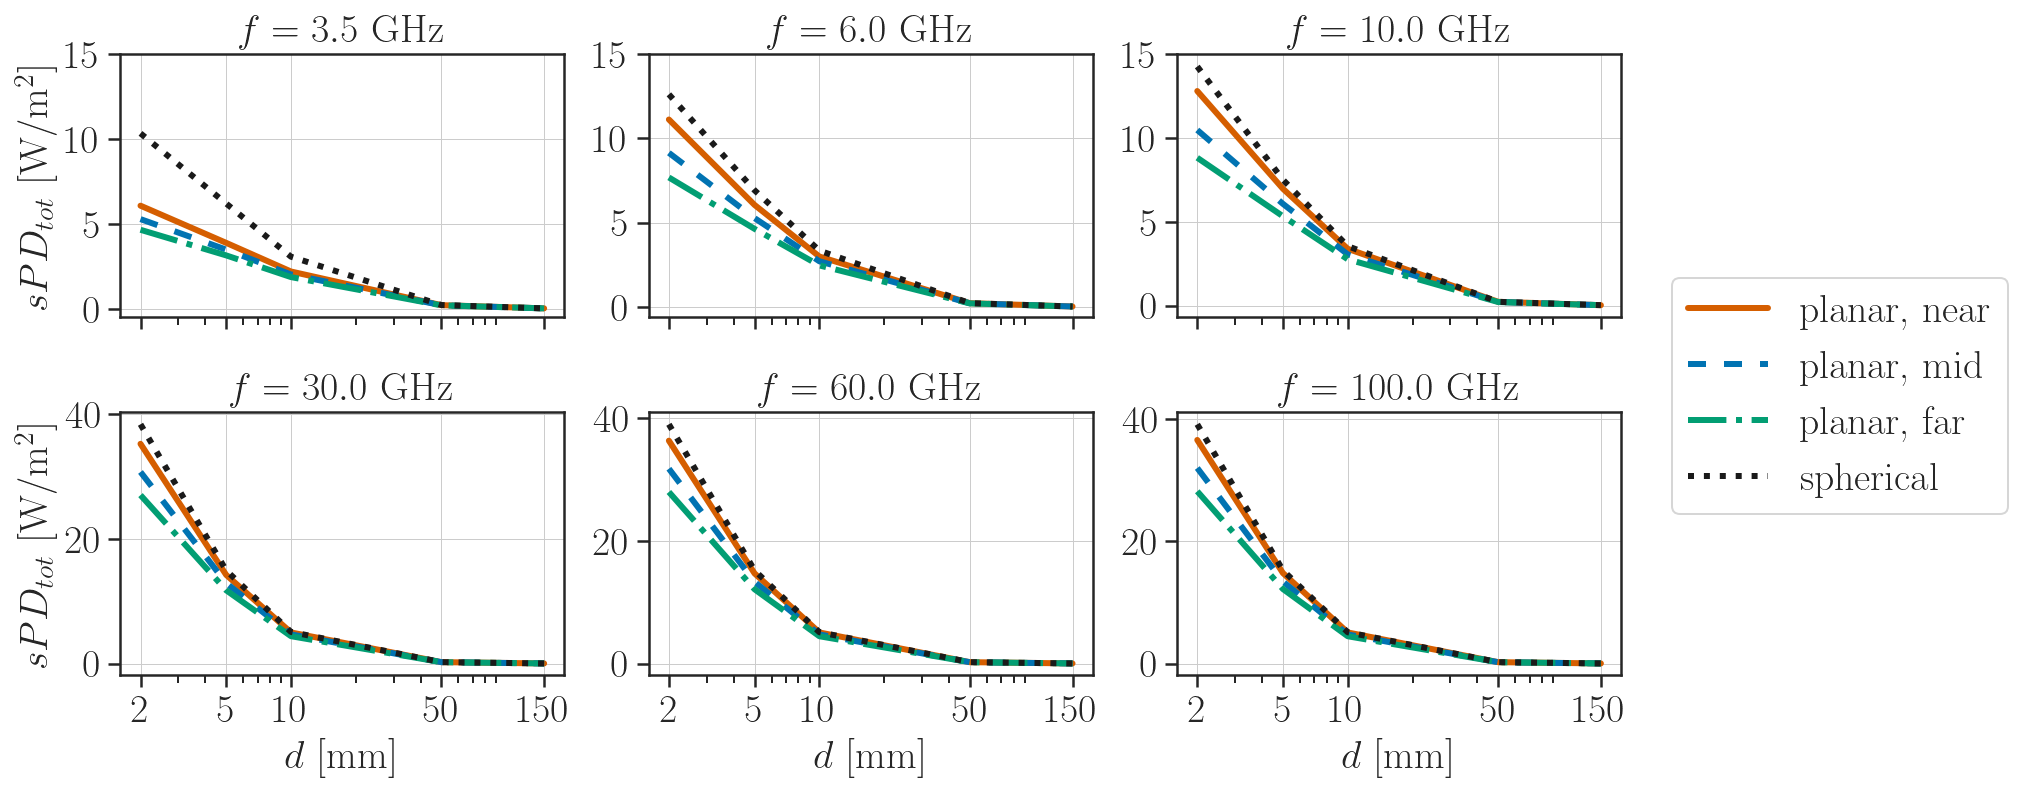

In [201]:
# visualize sPDtot for planar models and the spherical model w.r.t. distances for range of frequencies

n_rows = 2
n_cols = 3
fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
f_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        axs[row, col].plot(np.abs(ds_r), sPDtot_comp_r[f_idx::fs.size, 3], 'r-', label='planar, near')
        axs[row, col].plot(np.abs(ds_r), sPDtot_comp_r[f_idx::fs.size, 4], 'b--', label='planar, mid')
        axs[row, col].plot(np.abs(ds_r), sPDtot_comp_r[f_idx::fs.size, 5], 'g-.', label='planar, far')
        axs[row, col].plot(np.abs(ds_r), sPDtot_comp_r[f_idx::fs.size, 6], 'k:', label='spherical')
        print(sPDtot_comp_r[f_idx::fs.size, 5], sPDtot_comp_r[f_idx::fs.size, 6])
        axs[row, col].set_xscale('log')
        axs[row, col].grid()
        axs[row, col].set_xticks(ticks=np.abs(ds_r),
                                 labels=np.asarray(ds_r * -1000, dtype='int'))
        if col == 0:
            axs[row, col].set(ylabel='$sPD_{tot}$ [W/m$^2$]')
        if row == 1:
            axs[row, col].set(xlabel='$d$ [mm]')
            axs[row, col].set_yticks(ticks=[0, 20, 40])
        else:
            axs[row, col].set_yticks(ticks=[0, 5, 10, 15])
        axs[row, col].set(title=f'$f = {fs[f_idx]}$ GHz')
        f_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.8);

fname = os.path.join('figures', 'sPDtot_d_sim')
save_fig(fig, fname=fname)

[41.22539    37.375446   28.419231    2.6602209   0.10054962] [54.96361   49.285103  39.14801    8.436324   2.2964063]
[11.83792    12.542018   10.566038    0.25983572  0.11137025] [39.094746 33.058376 26.302824  6.417831  2.09825 ]
[10.251888    7.189135    4.4179883   0.48558223  0.17789729] [38.156017 29.045042 22.051094  5.802923  2.036022]
[8.152732   4.78716    1.5869681  0.08305816 0.01751604] [29.593033   21.31111    13.416968    2.9091306   0.99971366]
[6.8418226  3.220801   0.75606215 0.11140142 0.02041305] [28.281101  20.230532  12.8404875  2.8831997  0.9968865]
[6.543272   2.8802717  0.5716921  0.11747769 0.02107381] [28.002968  19.992043  12.713639   2.8776047  0.9962337]


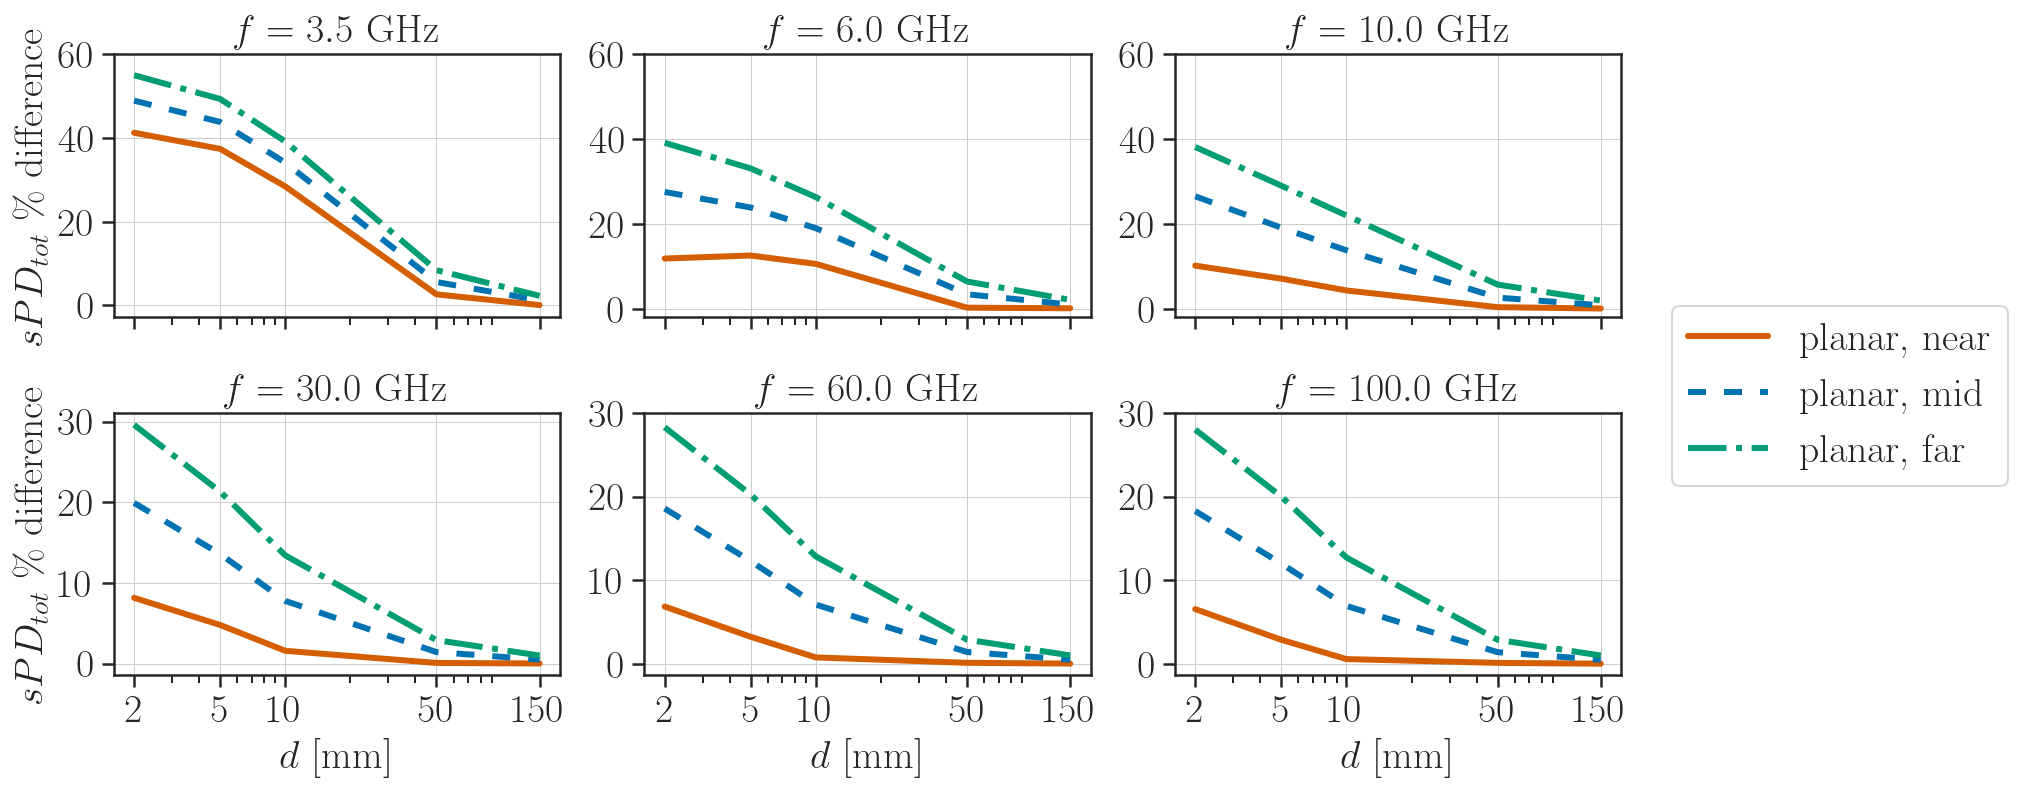

In [202]:
# visualize the absolute percentage difference in sPDn for planar models and the spherical model

fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
f_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        abs_diff_near = jnp.abs((sPDtot_comp_r[f_idx::fs.size, 3] - sPDtot_comp_r[f_idx::fs.size, 6]) / sPDtot_comp_r[f_idx::fs.size, 6])
        abs_diff_mid = jnp.abs((sPDtot_comp_r[f_idx::fs.size, 4] - sPDtot_comp_r[f_idx::fs.size, 6]) / sPDtot_comp_r[f_idx::fs.size, 6])
        abs_diff_far = jnp.abs((sPDtot_comp_r[f_idx::fs.size, 5] - sPDtot_comp_r[f_idx::fs.size, 6]) / sPDtot_comp_r[f_idx::fs.size, 6])
        print(abs_diff_near * 100, abs_diff_far * 100)
        axs[row, col].plot(np.abs(ds_r), abs_diff_near * 100, 'r-', label='planar, near')
        axs[row, col].plot(np.abs(ds_r), abs_diff_mid * 100, 'b--', label='planar, mid')
        axs[row, col].plot(np.abs(ds_r), abs_diff_far * 100, 'g-.', label='planar, far')
        axs[row, col].set_xscale('log')
        axs[row, col].grid()
        axs[row, col].set_xticks(ticks=np.abs(ds_r),
                                 labels=np.asarray(ds_r * -1000, dtype='int'))
        if col == 0:
            axs[row, col].set(ylabel='$sPD_{tot}$ \% difference')
        if row == 1:
            axs[row, col].set(xlabel='$d$ [mm]')
            axs[row, col].set_yticks(ticks=[0, 10, 20, 30])
        else:
            axs[row, col].set_yticks(ticks=[0, 20, 40, 60])
        axs[row, col].set(title=f'$f = {fs[f_idx]}$ GHz')
        f_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.8);

fname = os.path.join('figures', 'sPDtot_d_diff')
save_fig(fig, fname=fname)

### (3) Spherical model, between $sPDn$ and $sPDtot$

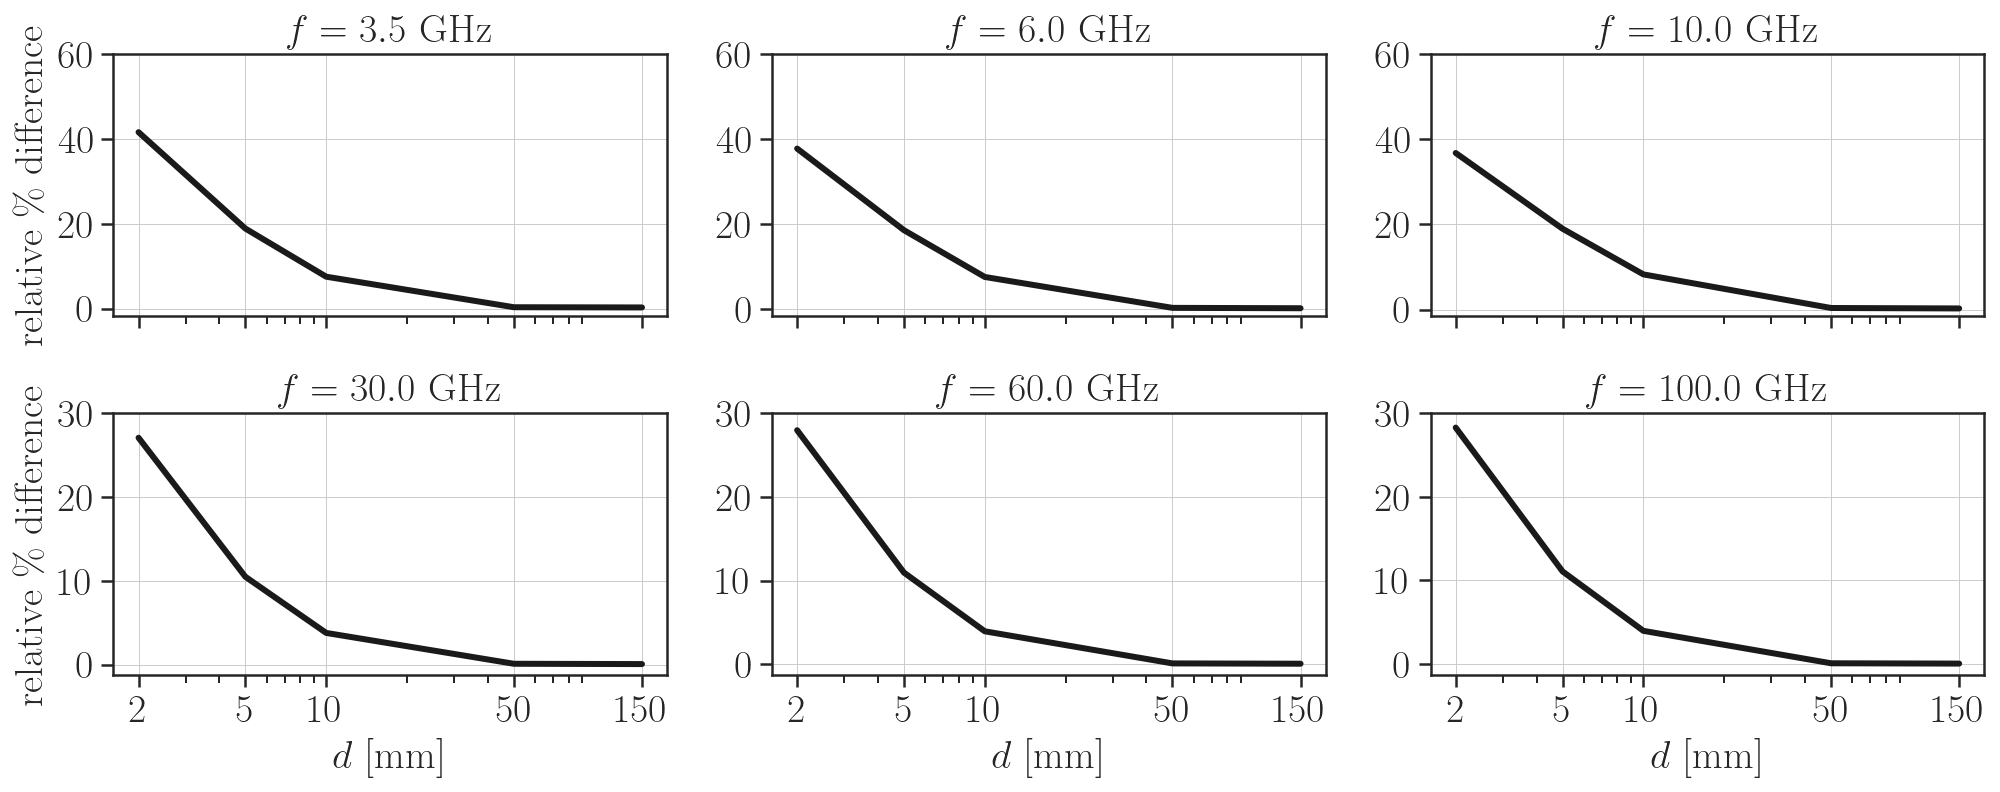

In [170]:
# visualize the difference between sPDn and sPDtot for the spherical model

n_rows = 2
n_cols = 3
fig_config(latex=True, text_size=20, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
f_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        diff = abs(sPDn_comp_r[f_idx::fs.size, 6] - sPDtot_comp_r[f_idx::fs.size, 6])
        ref = abs((sPDn_comp_r[f_idx::fs.size, 6] + sPDtot_comp_r[f_idx::fs.size, 6]) / 2)
        axs[row, col].plot(np.abs(ds_r), (diff / ref) * 100, 'k-')
        axs[row, col].set(xscale='log')
        axs[row, col].grid()
        axs[row, col].set_xticks(ticks=np.abs(ds_r),
                                 labels=np.asarray(ds_r * -1000, dtype='int'))
        if col == 0:
            axs[row, col].set(ylabel='relative \% difference')
        if row == 1:
            axs[row, col].set(xlabel='$d$ [mm]')
            axs[row, col].set_yticks(ticks=[0, 10, 20, 30])
        else:
            axs[row, col].set_yticks(ticks=[0, 20, 40, 60])
        axs[row, col].set(title=f'$f = {fs[f_idx]}$ GHz')
        f_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.tight_layout()

fname = os.path.join('figures', 'spherical_d_diff')
save_fig(fig, fname=fname)

In [182]:
idx = np.where(sPDn_comp_r[:, 0] == 30.)[0]
diff = sPDtot_comp_r[idx, 6] - sPDn_comp_r[idx, 6]
ref = ((sPDtot_comp_r[idx, 6] + sPDn_comp_r[idx, 6]) / 2)
rel_diff = (diff / ref) * 100

In [194]:
print(f'd = {ds * -1000}')
print(f'sPDn = {sPDn_comp_r[idx, 6].round(2)}')
print(f'sPDtot = {sPDtot_comp_r[idx, 6].round(2)}')
print(f'abs diff = {diff.round(2)}')
print(f'rel diff = {rel_diff.round(2)}')

d = [  2.   5.  10.  50. 150.]
sPDn = [29.22 13.46  4.89  0.23  0.03]
sPDtot = [3.838e+01 1.494e+01 5.080e+00 2.300e-01 3.000e-02]
abs diff = [9.15 1.49 0.19 0.   0.  ]
rel diff = [27.08 10.48  3.78  0.1   0.06]
